<a href="https://colab.research.google.com/github/mayurrrrr18/univariate-time-series2/blob/main/electricty_usage_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [7]:
# Load the dataset
file_path = 'Electric_Production.csv'
df_prod = pd.read_csv(file_path)

# Rename columns for clarity
df_prod.columns = ['Date', 'Production']

# Convert 'Date' to datetime and set as index
df_prod['Date'] = pd.to_datetime(df_prod['Date'])
df_prod.set_index('Date', inplace=True)

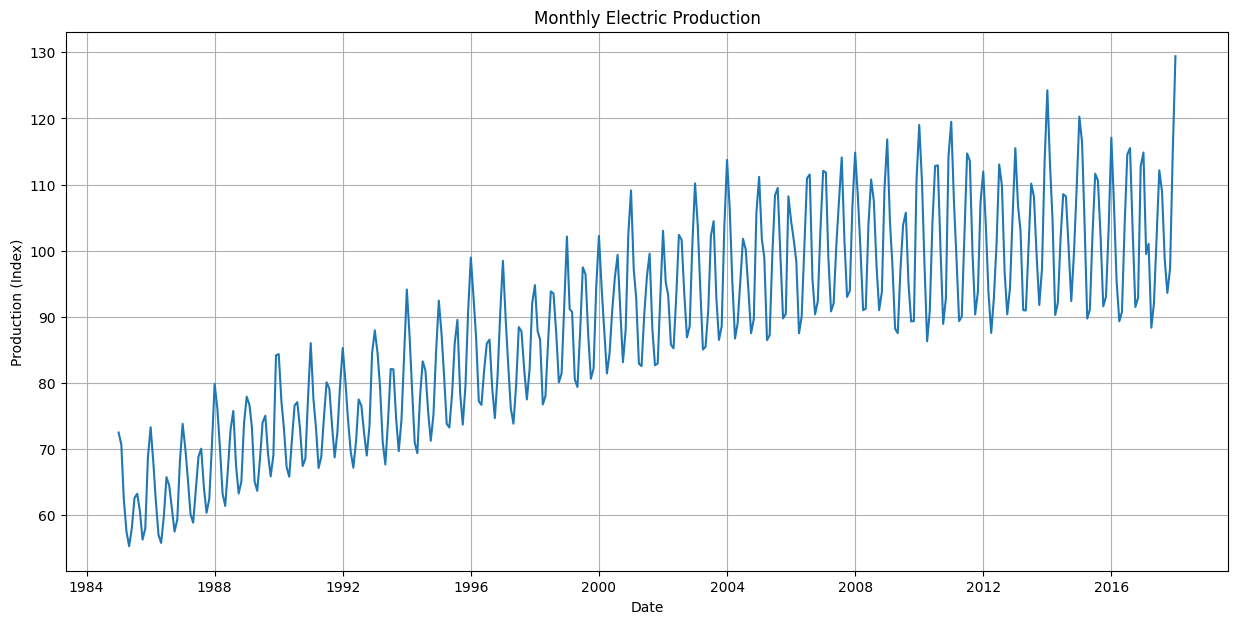

In [8]:
# Visualize the original time series data
plt.figure(figsize=(15, 7))
plt.plot(df_prod['Production'])
plt.title('Monthly Electric Production')
plt.xlabel('Date')
plt.ylabel('Production (Index)')
plt.grid(True)
plt.show()

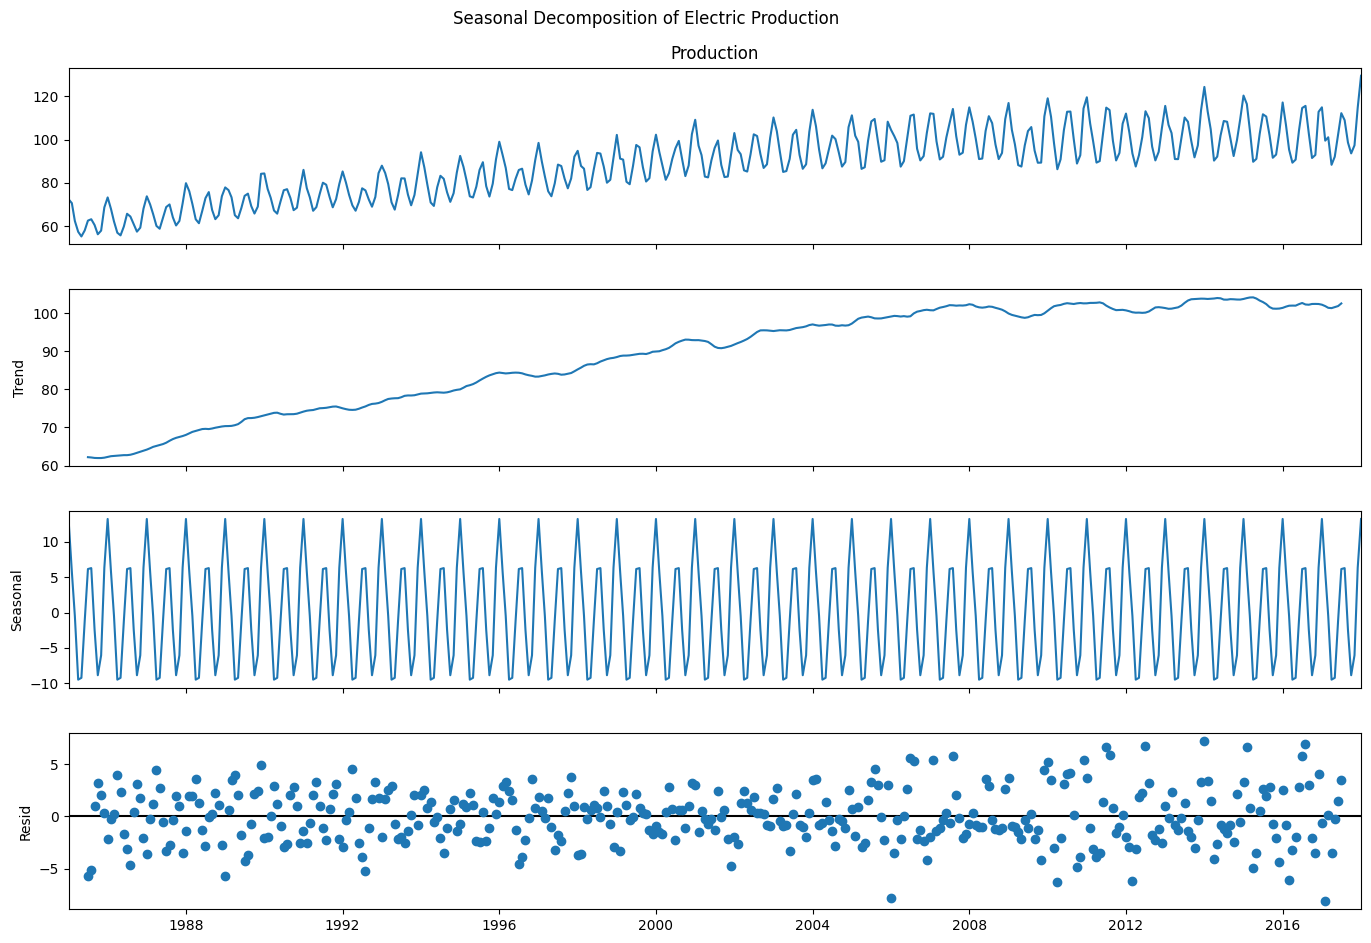

In [9]:
# Decompose the time series to visualize trend, seasonality, and residuals
decomposition = seasonal_decompose(df_prod['Production'], model='additive')
fig = decomposition.plot()
fig.set_size_inches(15, 10)
plt.suptitle('Seasonal Decomposition of Electric Production')
plt.show()

In [10]:

# Function to run ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print("\nConclusion: The series is likely stationary.")
    else:
        print("\nConclusion: The series is likely non-stationary. Differencing is required.")

# Step 2: Check for stationarity on the original data
print("\n--- ADF test on the original production data ---")
adf_test(df_prod['Production'])


--- ADF test on the original production data ---
ADF Statistic: -2.256990350047235
p-value: 0.1862146911658712
Critical Values:
	1%: -3.4476305904172904
	5%: -2.869155980820355
	10%: -2.570827146203181

Conclusion: The series is likely non-stationary. Differencing is required.


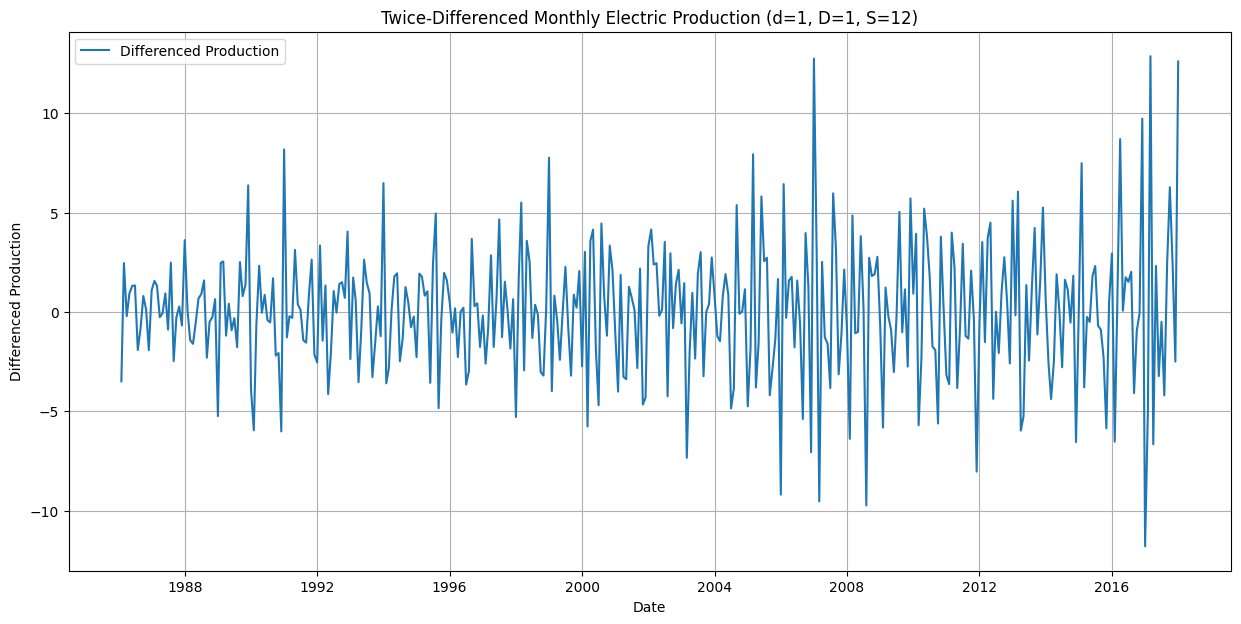

In [13]:
# Perform both regular and seasonal differencing and create a new series
production_diff = df_prod['Production'].diff().diff(12).dropna()

# Visualize the twice-differenced data
plt.figure(figsize=(15, 7))
plt.plot(production_diff, label='Differenced Production')
plt.title('Twice-Differenced Monthly Electric Production (d=1, D=1, S=12)')
plt.xlabel('Date')
plt.ylabel('Differenced Production')
plt.grid(True)
plt.legend()
plt.show()

In [14]:
# Run the ADF test on the differenced data
print("\n--- ADF test on the twice-differenced data ---")
adf_test(production_diff)



--- ADF test on the twice-differenced data ---
ADF Statistic: -8.022039209985028
p-value: 2.0639252090769555e-12
Critical Values:
	1%: -3.4482453822848496
	5%: -2.8694261442901396
	10%: -2.5709711770439507

Conclusion: The series is likely stationary.



--- ACF and PACF plots for the twice-differenced data ---


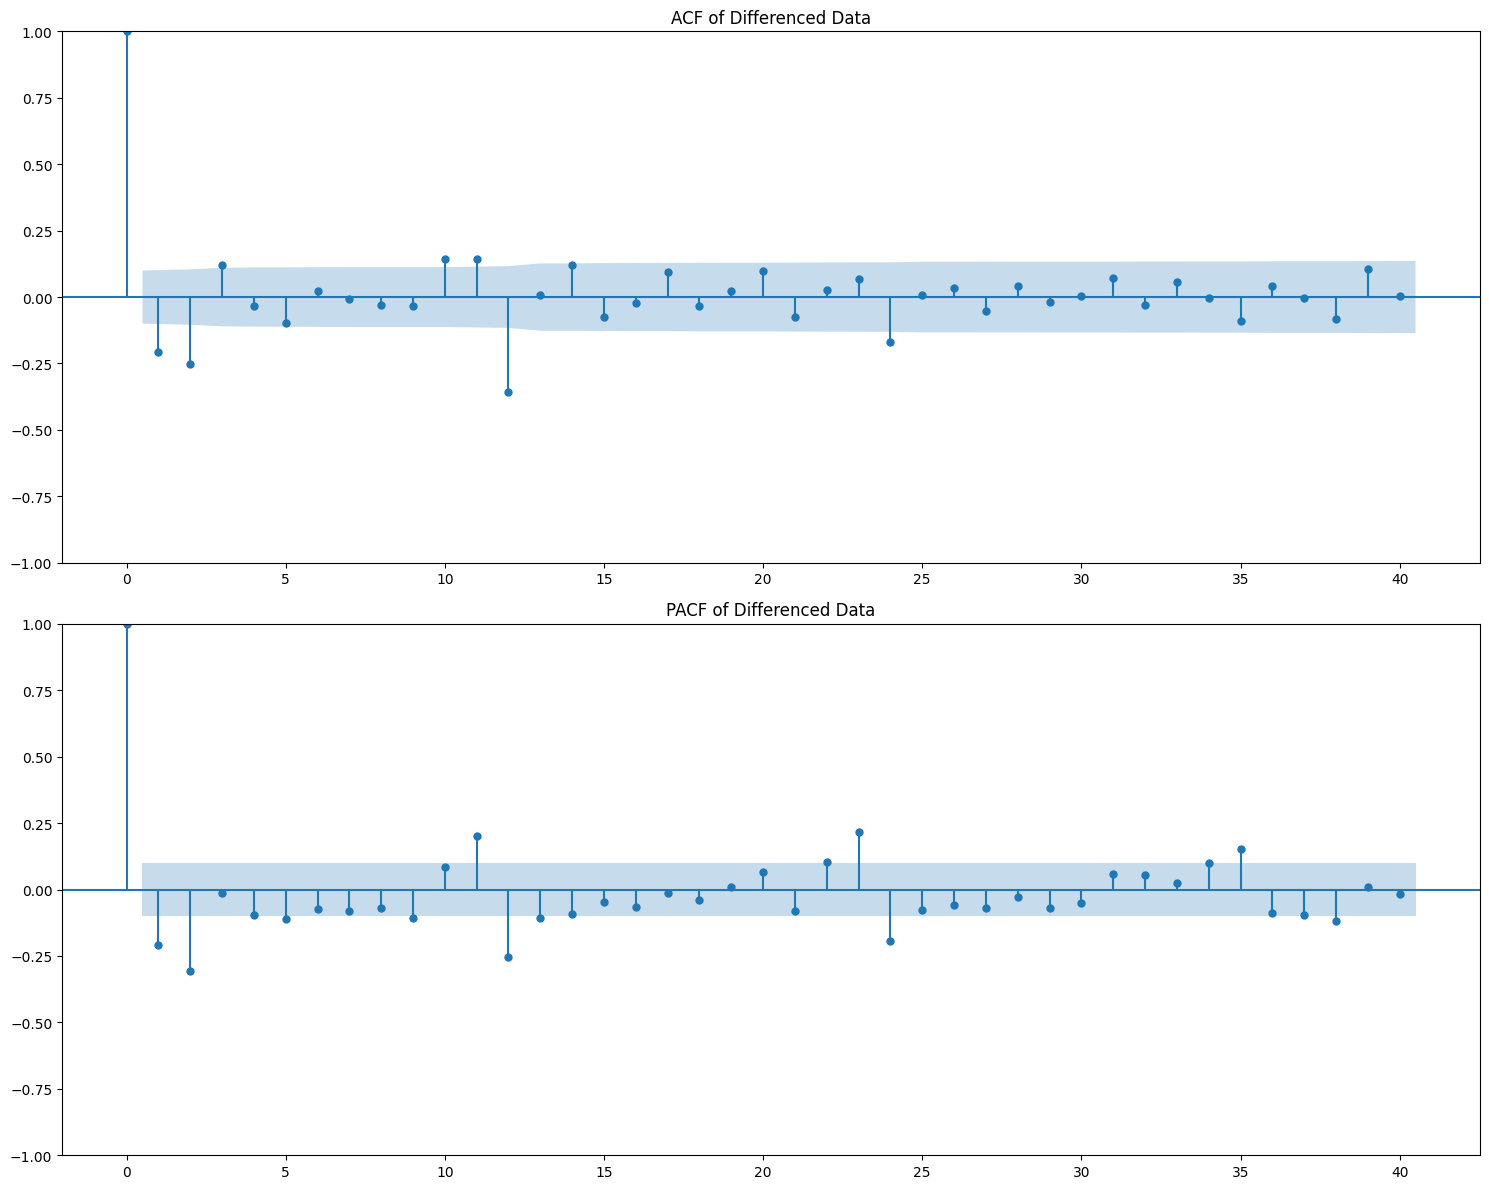

In [15]:
# Step 3: Identify SARIMA parameters using ACF and PACF plots
print("\n--- ACF and PACF plots for the twice-differenced data ---")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
plot_acf(production_diff, ax=ax1, lags=40, title='ACF of Differenced Data')
plot_pacf(production_diff, ax=ax2, lags=40, title='PACF of Differenced Data')
plt.tight_layout()
plt.show()


In [17]:
# Step 4: Model Building and Evaluation
# Split the data into training and testing sets
train_size = int(len(df_prod) * 0.8)
train, test = df_prod['Production'].iloc[:train_size], df_prod['Production'].iloc[train_size:]

# Fit the SARIMAX model with the identified parameters
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

# Print the model summary
print(sarima_fit.summary())

# Make predictions on the test set
test_predictions = sarima_fit.forecast(steps=len(test))

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(test, test_predictions))
print(f"\nRoot Mean Squared Error (RMSE) on test set: {rmse:.2f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         Production   No. Observations:                  317
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -675.006
Date:                            Tue, 05 Aug 2025   AIC                           1360.012
Time:                                    17:43:24   BIC                           1378.597
Sample:                                01-01-1985   HQIC                          1367.446
                                     - 05-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5070      0.058      8.772      0.000       0.394       0.620
ma.L1         -0.9545      0.020   

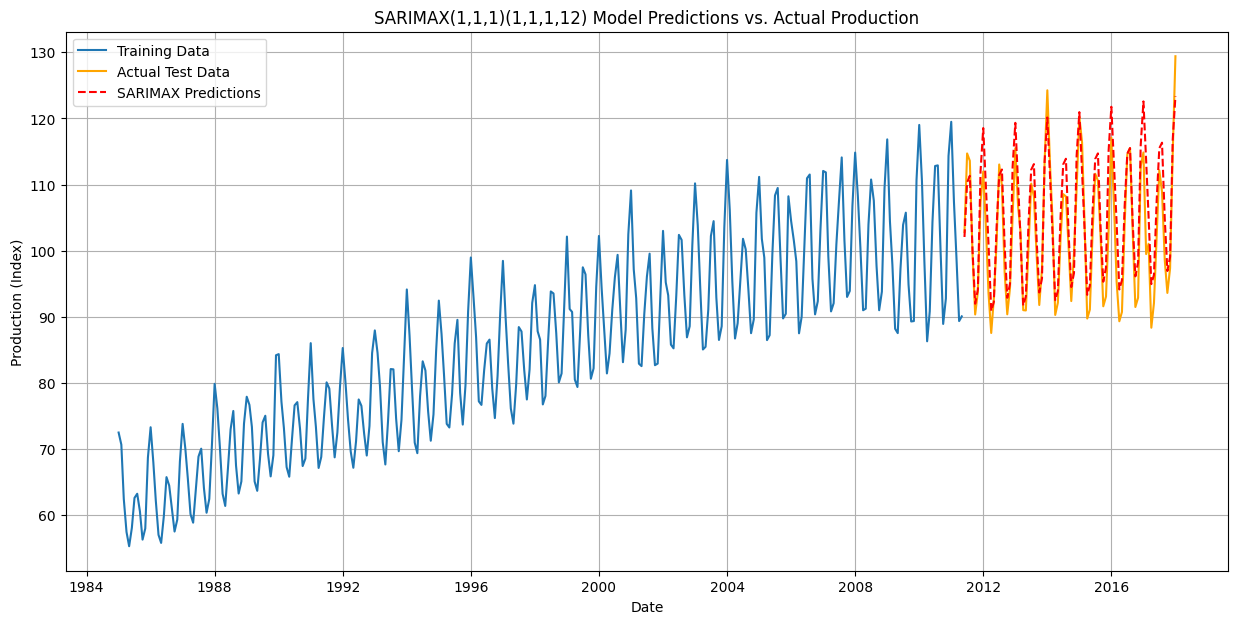

In [18]:
# Plotting the training data, actual test data, and the predictions
plt.figure(figsize=(15, 7))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Test Data', color='orange')
plt.plot(test.index, test_predictions, label='SARIMAX Predictions', color='red', linestyle='--')
plt.title('SARIMAX(1,1,1)(1,1,1,12) Model Predictions vs. Actual Production')
plt.xlabel('Date')
plt.ylabel('Production (Index)')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Step 5: Forecasting future production
future_forecast_steps = 24
future_forecast = sarima_fit.forecast(steps=future_forecast_steps)

# Create a new index for the forecasted data
last_date = df_prod.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_forecast_steps + 1, freq='MS')[1:]


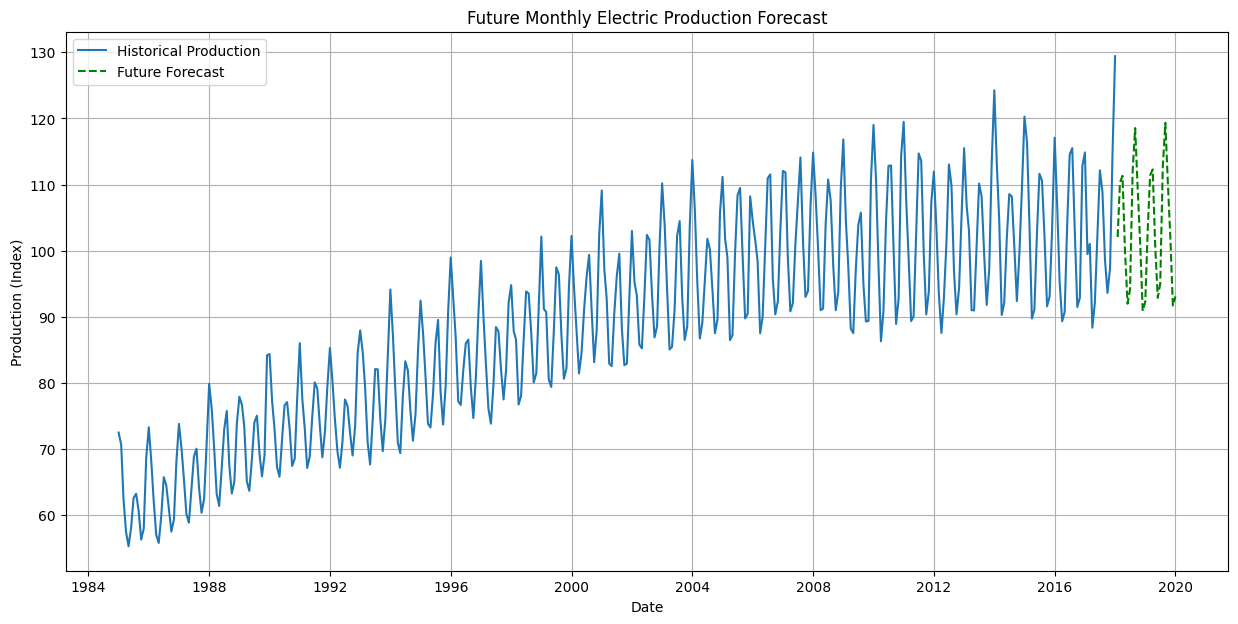

In [20]:
# Plot the historical data and the future forecast
plt.figure(figsize=(15, 7))
plt.plot(df_prod['Production'], label='Historical Production')
plt.plot(future_dates, future_forecast, label='Future Forecast', color='green', linestyle='--')
plt.title('Future Monthly Electric Production Forecast')
plt.xlabel('Date')
plt.ylabel('Production (Index)')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Display the forecasted values
print("Forecasted Values:")

# Combine the forecasted dates and values into a DataFrame for clear presentation
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted Production': future_forecast.values
})

# Display the DataFrame
print(forecast_df)

Forecasted Values:
         Date  Forecasted Production
0  2018-02-01             102.071906
1  2018-03-01             110.314498
2  2018-04-01             111.326699
3  2018-05-01              99.946946
4  2018-06-01              91.982577
5  2018-07-01              94.156392
6  2018-08-01             111.955318
7  2018-09-01             118.544482
8  2018-10-01             109.494570
9  2018-11-01             100.993989
10 2018-12-01              90.885398
11 2019-01-01              92.251450
12 2019-02-01             103.539417
13 2019-03-01             111.429211
14 2019-04-01             112.279533
15 2019-05-01             100.833229
16 2019-06-01              92.876934
17 2019-07-01              94.999877
18 2019-08-01             112.724867
19 2019-09-01             119.331779
20 2019-10-01             110.329654
21 2019-11-01             101.823766
22 2019-12-01              91.708364
23 2020-01-01              93.084880
